# Example – Pool Fire

## Introduction

This example illustrates the setup and analysis of a minimalistic FDS simulation. A simple pool fire with a fixed heat release rate is computed. The example will be used to explain the modelling and analysis of a simple fire in FDS. The results will be validated by comparing them with simple analytical formulas.

## Setup

The scenario is a pool fire with a heat release rate of $\small\sf 1~MW$ and a surface area of $\small\sf 1~m^2$ is located centraly at the floor, i.e. $\small\sf z=0~m$. The extension of the compuatational domain is 

$$\small\sf [-2.5~m, 2.5~m] \times [-2.5~m, 2.5~m] \times [0~m, 10~m]$$ 

with a grid resolution of $\small\sf 0.1~m$.

## FDS Input File

Parameters in the FDS input file are specified by using namelist formatted records. Each namelist record begins with the ampersand character, &, followed by the name of the namelist group, then a comma-delimited list of the input parameters, and finally a forward slash /.

```{tip} Table 21.3 in the [FDS User's Guide](https://github.com/firemodels/fds/releases/download/FDS6.7.5/FDS_User_Guide.pdf) provides a summary of frequently used output quantities.  
```

A simple and commented input file that can serve as a starting point for the following exercise looks like this:

```{literalinclude} ../../../../data/pool_fire/misc/pool_fire_basic_comments.fds
```

## SMV Visualisation

The computational domain as well as the boundary conditions and the output quantities of the FDS simulation can be displayed using the Smokeview postprocessor. The 

:::{figure-md} fig-pool-fire-smv-plain

<img src="figs/pool_fire_all.png" width="100%">

SMV visualisation of the geometry / the mesh-grid in the y-z-plane / the temperature values in the y-z-slice at  $\sf y=0~m$ ($\sf t=19.63~s$). The surface patch `BURNER`, which has a `HRRPUA` defined, is colored redish.  
:::

## Analysis

## Task I – Basics

The goal of this task is to become familiar with basic functions. Use the above listed input file and extend it.

```{tip} When adding new diagnostics or other elements, it is useful to reduce the computing time to allow for a fast turn-over-time. This way debugging or adjusting your setup will be more efficient. For pure geometrical checks, the simulaiton time can also be set to zero.  
```


**Task:**

1. Add a temperature sclice at $\small\sf y=0~m$ and watch the output via smokeview. Change the output by varying the colour scaling and crop the data in an upper and lower boundary. Create snapshots for three points in time, e.g. $\small\sf 10~s$, $\small\sf 75~s$ and $\small\sf 150~s$.

2. Plot the computed heat release rate (HRR) from the pool_fire_hrr.csv file against the given input HRR of the FDS file. Discuss the differences in what these are related to. Compare HRR for heat release rates of $\small\sf 100~kW$, $\small\sf 1~MW$ and $\small\sf 10~MW$.

**Solution**

:::{figure-md} fig-pool-fire-temp-timesteps

<img src="figs/pool_fire_temp_timesteps.png" width="100%">

Visualisation of the instanteneous `TEMPERATURE` values in the y-z-slice $\sf y=0~m$ at different timesteps ($\sf t=5.03~s$), ($\sf t=10.03~s$), ($\sf t=20.03~s$) The command `CELL_CENTERED`, prevents the values between the cell boundaries from being interpolated.
:::

:::{figure-md} fig-pool-fire-temp-bounds-trunc

<img src="figs/pool_fire_temp_bounds_trunc.png" width="100%">

Visualisation of the instanteneous `TEMPERATURE` values in the y-z-slice $\sf y=0~m$ at ($\sf t=19.63~s$) The upper data bound is set to 1200 and 800. The data is truncated beyond 100,
:::

In [1]:
import fdsreader
import numpy as np
import matplotlib.pyplot as plt

# plt.rcParams['figure.dpi'] = 150
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

root = '../../../../'

In [2]:
data_root = root + 'data/pool_fire/100kw_sealed'
sim = fdsreader.Simulation(data_root)
plt.plot(sim.hrr["Time"], sim.hrr["HRR"], label='simulation')
t_min_max = [sim.hrr["Time"][0], sim.hrr["Time"][-1]]
hrr_prescribed = 100
plt.plot(t_min_max, [hrr_prescribed, hrr_prescribed], label='prescribed')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.xlabel("Time / s")
plt.ylabel("HRR / kW")
plt.savefig('figs/pool_fire_100kw_sealed_hrr.svg', bbox_inches='tight')
plt.close()

In [3]:
data_root = root + 'data/pool_fire/1mw_sealed'
sim = fdsreader.Simulation(data_root)
plt.plot(sim.hrr["Time"], sim.hrr["HRR"], label='simulation')
t_min_max = [sim.hrr["Time"][0], sim.hrr["Time"][-1]]
hrr_prescribed = 1000
plt.plot(t_min_max, [hrr_prescribed, hrr_prescribed], label='prescribed')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.xlabel("Time / s")
plt.ylabel("HRR / kW")
plt.savefig('figs/pool_fire_1mw_sealed_hrr.svg', bbox_inches='tight')
plt.close()

In [4]:
data_root = root + 'data/pool_fire/10mw_sealed'
sim = fdsreader.Simulation(data_root)
plt.plot(sim.hrr["Time"], sim.hrr["HRR"], label='simulation')
t_min_max = [sim.hrr["Time"][0], sim.hrr["Time"][-1]]
hrr_prescribed = 10000
plt.plot(t_min_max, [hrr_prescribed, hrr_prescribed], label='prescribed')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.xlabel("Time / s")
plt.ylabel("HRR / kW")
plt.savefig('figs/pool_fire_10mw_sealed_hrr.svg', bbox_inches='tight')
plt.close()

The fluctuation of the HRR curve increases at higher levels. A drop in the energy release with time indicates a lower oxygen level due to the sealed  compartment.

```{tabbed} 100 kW
<img src="figs/pool_fire_100kw_sealed_hrr.svg" width="80%">
```

```{tabbed} 1 MW
<img src="figs/pool_fire_1mw_sealed_hrr.svg" width="80%">
```

```{tabbed} 10 MW
<img src="figs/pool_fire_10mw_sealed_hrr.svg" width="80%">
```

## Task II – Mean Profiles

This task will illustrate the analysis of the simulation based on slices and devices. In addition to the heat release, the gas temperature should also be evaluated. Use again the input file with a heat release of 1 MW.

```{tip} Use the Python FDS Reader to evaluate the cell temperatures at stated height.
```

**Tasks**
1. At a hight of $\small\sf z = 1.5~m$ plot a contour plot that shows the isothermes for the temperature distribution.

2. Visualalise the velcity vector field in the plume axis at $\small\sf t = 20~s$. Open the sealed domain on at least one side and observe the change in the flow field. 

3. Analyse the heat flux and the adiabatic surface temperature on the boundaries of the domain or an obstruction within. Plot the quantities with Smokeview or by reading the boundary file with the ***fdsreader*** and. Compare the devices in the center of the boundaries. Consider the orientation of the devices


```{tip} A vector field results from the superposition of several scalar fields (e.g. u- and v-velocity).
```

[comment]: <> (v_z profile along z-axis as function of HRR)

**Solution**

In [5]:
data_root = root + 'data/pool_fire/1mw_sealed'
sim = fdsreader.Simulation(data_root)
slice_temp = sim.slices[0]
time = 20
time_index = slice_temp.get_nearest_timestep(time)

plt.figure(figsize=(4,6))
plt.imshow(slice_temp[0].data[time_index].T, origin='lower', 
           extent=slice_temp[0].extent.as_list(), cmap='jet',
           vmin=20, vmax=1200)
plt.xlabel("X / m")
plt.ylabel("Z / m")
plt.colorbar(label="Temperature / $\sf ^\circ C$")
plt.savefig('figs/pool_fire_1mw_temperatures_slice.svg', bbox_inches='tight')
plt.close()



:::{figure-md} fig-pool-fire-temp-slice

<img src="figs/pool_fire_1mw_temperatures_slice.svg" width="60%">

Visualisation of the instanteneous ($\sf t=19.63~s$) `TEMPERATURE` values in the y-z-slice $\sf y=0~m$. The command `CELL_CENTERED`, prevents the values between the cell boundaries from being interpolated.
:::

In [6]:
slice_temp = sim.slices[1]
time = 20.00
time_index = slice_temp.get_nearest_timestep(time)
(n_x, n_y) = slice_temp[0].shape
x = range(n_x)
y = range(n_y)
X, Y = np.meshgrid(x, y)
plt.figure(figsize=(3,3))
plt.contourf(X,Y, slice_temp[0].data[time_index].T, origin='lower', cmap='jet')
plt.xlabel("$\sf N_{cells,x}$ / -")
plt.ylabel("$\sf N_{cells,y}$ / -")
plt.colorbar(label="Temperature / $\sf ^\circ C$")
plt.savefig('figs/pool_fire_1mw_temperatures_z_contour.svg', bbox_inches='tight')
plt.close()

:::{figure-md} fig-pool-fire-temp-contour

<img src="figs/pool_fire_1mw_temperatures_z_contour.svg" width="60%">

Visualisation of the instanteneous ($\sf t=19.63~s$) temperature values in the x-z-slice $\sf y=0~m$. The plot shows the isotherms with a bandwidth of $100 K$.
:::

In [7]:
data_root = root + 'data/pool_fire/10mw_sealed'
sim = fdsreader.Simulation(data_root)# Vector Plots
time = 20
time_index = slice_temp.get_nearest_timestep(time)


slice_u = sim.slices[3][0].data[time_index]
slice_v = sim.slices[4][0].data[time_index]
n_x = slice_u.shape[0]
n_y = slice_u.shape[1]
x = range(n_x)
y = range(n_y)
X, Y = np.meshgrid(x, y)
slice_res = (slice_u**2 + slice_v**2)**1/2
plt.figure(figsize=(4,6))
plt.quiver(X,Y, slice_u.T, slice_v.T, slice_res.T,cmap='jet', clim=(0,50), scale=100)
plt.colorbar(label = "Velocity / $\sf ms^{-2}$")
plt.xlabel("$\sf N_{cells,x}$ / -")
plt.ylabel("$\sf N_{cells,y}$ / -")
plt.xticks(ticks=[0,12.5,25], labels=[-2.5,0,2.5])
plt.yticks(ticks=[0,10,20,30,40,50], labels=[0,2,4,6,8,10])
plt.xlim(0,25)
plt.savefig('figs/velocity_vector_sealed.svg', bbox_inches='tight')
plt.close()

In [8]:
data_root = root + 'data/pool_fire/10mw_open'
sim = fdsreader.Simulation(data_root)# Vector Plots
time = 20
time_index = slice_temp.get_nearest_timestep(time)


slice_u = sim.slices[3][0].data[time_index]
slice_v = sim.slices[4][0].data[time_index]
n_x = slice_u.shape[0]
n_y = slice_u.shape[1]
x = range(n_x)
y = range(n_y)
X, Y = np.meshgrid(x, y)
slice_res = (slice_u**2 + slice_v**2)**1/2
plt.figure(figsize=(3,6))
plt.quiver(X,Y, slice_u.T, slice_v.T, slice_res.T,cmap='jet', clim=(0,50), scale=100)
plt.colorbar(label = "Velocity / $\sf ms^{-2}$")

plt.xlabel("$\sf N_{cells,x}$ / -")
plt.ylabel("$\sf N_{cells,y}$ / -")
plt.xticks(ticks=[0,12.5,25], labels=[-2.5,0,2.5])
plt.yticks(ticks=[0,10,20,30,40,50], labels=[0,2,4,6,8,10])
plt.xlim(0,25)
plt.savefig('figs/velocity_vector_open.svg', bbox_inches='tight')
plt.close()


```{tabbed} 10 MW, sealed domain
<img src="figs/velocity_vector_sealed.svg" width="60%">
```

```{tabbed} 10 MW, open domain
<img src="figs/velocity_vector_open.svg" width="60%">
```

In [9]:
from fdsreader.bndf.utils import sort_patches_cartesian
data_root = root + 'data/pool_fire/bndf'
sim = fdsreader.Simulation(data_root)
obst = sim.obstructions[0]

orientation = -1
quantity = "AST"
patches = list()
for sub_obst in obst.filter_by_orientation(orientation):
    # Get boundary data for a specific quantity
    sub_obst_data = sub_obst.get_data(quantity)
    patches.append(sub_obst_data.data[orientation])

# Combine patches to a single face for plotting
patches = sort_patches_cartesian(patches)

shape_dim1 = sum([patch_row[0].shape[0] for patch_row in patches])
shape_dim2 = sum([patch.shape[1] for patch in patches[0]])
n_t = patches[0][0].n_t  # Number of timesteps

face = np.empty(shape=(n_t, shape_dim1, shape_dim2))
dim1_pos = 0
dim2_pos = 0
for patch_row in patches:
    d1 = patch_row[0].shape[0]
    for patch in patch_row:
        d2 = patch.shape[1]
        face[:, dim1_pos:dim1_pos + d1,
        dim2_pos:dim2_pos + d2] = patch.data
        dim2_pos += d2
    dim1_pos += d1
    dim2_pos = 0

t = 20
plt.figure(figsize=(4,6))
plot = plt.imshow(face[t].T, vmin=20, vmax=300, origin="lower", cmap="jet")
plt.colorbar(label="Temperature / $\sf ^\circ C$")
plt.xlabel("$\sf N_{cells,x}$ / -")
plt.ylabel("$\sf N_{cells,y}$ / -")
plt.savefig('figs/bndf_ast.svg', bbox_inches='tight')
plt.close()

In [10]:
orientation = -1
quantity = "NET HEAT FLUX"
patches = list()
for sub_obst in obst.filter_by_orientation(orientation):
    # Get boundary data for a specific quantity
    sub_obst_data = sub_obst.get_data(quantity)
    patches.append(sub_obst_data.data[orientation])

# Combine patches to a single face for plotting
patches = sort_patches_cartesian(patches)

shape_dim1 = sum([patch_row[0].shape[0] for patch_row in patches])
shape_dim2 = sum([patch.shape[1] for patch in patches[0]])
n_t = patches[0][0].n_t  # Number of timesteps

face = np.empty(shape=(n_t, shape_dim1, shape_dim2))
dim1_pos = 0
dim2_pos = 0
for patch_row in patches:
    d1 = patch_row[0].shape[0]
    for patch in patch_row:
        d2 = patch.shape[1]
        face[:, dim1_pos:dim1_pos + d1,
        dim2_pos:dim2_pos + d2] = patch.data
        dim2_pos += d2
    dim1_pos += d1
    dim2_pos = 0

t = 20
plt.figure(figsize=(4,6))
plot = plt.imshow(face[t].T, vmin=0, vmax=4, origin="lower", cmap="jet")
plt.colorbar(label="NHF / $\sf kW~m^{-2}$")
plt.xlabel("$\sf N_{cells,x}$ / -")
plt.ylabel("$\sf N_{cells,y}$ / -")
plt.savefig('figs/bndf_nhf.svg', bbox_inches='tight')
plt.close()

In [11]:
time = sim.devices['Time'].data
ast = sim.devices['AST'].data
nhf = sim.devices['NHF'].data
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.plot(ast, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('Time / s')
ax1.set_ylabel("AST / $\sf ^\circ C$", color=color)


ax2 = ax1.twinx()
color = 'tab:orange'

ax2.plot(nhf, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("NHF / $\sf kW~m^{-2}$", color=color)

plt.savefig('figs/pool_fire_1mw_ast_nhf.svg', bbox_inches='tight')
plt.close()

```{tabbed} ADIABATIC SURFACE TEMPERTURE
<img src="figs/bndf_ast.svg" width="60%">
```
```{tabbed} NET HEAT FLUX
<img src="figs/bndf_nhf.svg" width="60%">
```

## Task III - Plume Formulas

This task targets the computation of the flame temperature with analytical methods in order to subsequently validate the results of an numerical simulation. For more detailed information on the theory and application of the Plume formulas, please refer to the literature, e.g. Enclosure Fire Dynamics by B. Karlsson and J. Quintiere.

***Heskested***

$$ \small\sf
\Delta T = 9.1 \left(\frac{T_\infty}{g \cdot c_p^2 \cdot \rho_\infty^2} \right)^{1/3} \cdot \dot{Q}_c^{2/3} \cdot (z -z_0)^{-5/3}
$$

The virtual origin $z_0$ depends on the (equivalent) diameter $D$ of the fire source and the total heat release rate and is given by:

$$\small\sf
z_0 = 0.083 \cdot \dot{Q}_c^{2/5} - 1.02 \cdot D
$$

where $\sf \dot{Q}_c$ ist the convective heat release rate, $\small\sf T_\infty = 293~K$ is the ambient temperature, $\small\sf g = 9.81~ms^{-1}$ is the gravitational constant, $\small\sf \rho_\infty = 1.2 kg/m^3$ is the 
density of ait at ambient temperature and $\small\sf c_p = 1.0~kJ/(kg K)$ is the specific heat capacity.

***McCaffrey***

$$\small\sf
\Delta T = \left(\frac{\kappa}{0.9 \cdot \sqrt{2g}}\right)^2 \cdot \left(\frac{z}{\dot{Q}^{2/5}}\right)^{2\eta-1} \cdot T_\infty
$$

where $\small\sf \dot{Q}$ ist the total heat release rate, $\small\sf T_\infty = 293~K$ is the ambient temperature, $\small\sf g = 9.81~ms^{-1}$ is the gravitational constant, z is the hight above the virtual plume source (m), The constants $\small\sf \eta$ and $\small\sf \kappa$ vary depending on the plume regions and can be optained from the following table.

| Region       | $ \small\sf \frac{z}{\dot{Q}^{2/5}}$    | $\small\sf \eta$ | $\small\sf \kappa$           |
|--------------|---------------------|--------|-----------------------------|
| Continuous   | < 0.08           | 1/2  | $\small\sf 6.8~[m^{1/2}/s]$           |
| Intermittent | 0.08-0.2         |  0    | $\small\sf 1.9~[m/(kW^{1/5}s)]$       |
| Plume        | > 0.2            | 1/3 | $\small\sf 1.1~[m^{4/4}/(kW^{1/3}s)]$ |

**Task:**

1. Calculate the flame temperature of the plume uaing the analytical solutions of the Heskested and Mccaffrey Plumes at a HRR of 1 MW at hights of $\small\sf  z = 0.5~m, 1~m, 1.5~m, 2~m, 2.5~m, 4~m$. Assume that the radiative fraction of is plume is 20 %. Compare the results and discuss the reasons for the differences.

2. Evaluate the gas temperature in the plume axis by a slice file in the X-Z as well as in the Y-Z plane. Compare the temperature in the plume axis to the results of the plume formulas using temperature devices. Smooth the output of the devices over a moving average to reduce noise.

**Solution:**

***McCaffrey***

```{toggle}
$\small\sf z = 1.0 m: \frac{z}{\dot{Q}^{2/5}} = \frac{1}{1000^{2/5}} = 0.063 < 0.008$ -> Continuous

$\small\sf z = 1.5 m: \frac{z}{\dot{Q}^{2/5}} = \frac{1.5}{1000^{2/5}} = 0.2 > 0.095 > 0.008$ -> Intermediate

$\small\sf z = 2.0 m: \frac{z}{\dot{Q}^{2/5}} = \frac{2.0}{1000^{2/5}} = 0.2 > 0.126 > 0.008$ -> Intermediate

$\small\sf z = 2.5 m: \frac{z}{\dot{Q}^{2/5}} = \frac{2.5}{1000^{2/5}} = 0.2 > 0.158 > 0.008$ -> Intermediate

$\small\sf z = 4.0 m: \frac{z}{\dot{Q}^{2/5}} = \frac{4.0}{1000^{2/5}} = 0.252 > 0.2$ -> Plume

The calculated temperatures and the respective auxiliary constants used can be found in the following table:


| $\small\sf z [m]$ | $\small\sf \frac{z}{\dot{Q}^{2/5}}[m/kW^{2/5}]$  | $\small\sf \eta$ | $\small\sf \kappa$             | $\small\sf \Delta T [\circ C]$ |
|:-------:|:--------------------------------------:|:------:|:--------------------:|:--------------------:|
| 1.0     | 0.063                                  | 1/2    | $\small\sf 6.8~m^{1/1}/s$      |          852         |
| 1.5     | 0.095                                  | 0      | $\small\sf 1.9~m/(kW^{1/5}/s)$ |          700         |
| 2.0     | 0.126                                  | 0      | $\small\sf 1.9~m/(kW^{1/5}/s)$  |          528         |
| 2.5     | 0.158                                  | 0      | $\small\sf 1.9~m/(kW^{1/5}/s)$ |          421         |
| 4.0     | 0.252                                  | -1/3   | $\small\sf 1~m/(kW^{1/3}/s)$   |          221         |
```

***Heskested***
```{toggle}
Simplifying the plumem formula into:

$\small\sf \Delta T = 9.1 \left(\frac{T_\infty}{g \cdot c_p^2 \cdot \rho_\infty^2} \right)^{1/3} \cdot \dot{Q}_c^{2/3} \cdot (z -z_0)^{-5/3} = 25 \left( \frac{\dot{Q}_c^{2/5}}{(z -z_0)}\right)^{-5/3}$

The equivalent diameter:

$\small\sf D = 2 \sqrt{\frac{A}{2\pi}} = 2 \sqrt{\frac{1}{2\pi}} \approx 0.8$

The virtual plume origin:

$\small\sf z_0 = 0.083 \cdot (0.8 \cdot 1000)^{2/3} - 1.02 \cdot 0.8 \approx 0.39 m$

The Flame temperature at differenyt heights:

$\small\sf z = 1.0 m:$ $\small\sf \Delta T = 25 \left( \frac{800^{2/5}}{(1 + 0.39)}\right)^{5/3} = 1244 K$


$\small\sf z = 1.5 m:$ $\small\sf  \Delta T = 25 \left( \frac{800^{2/5}}{(1.5 + 0.39)}\right)^{5/3} = 745 K$


$\small\sf z = 2.0 m:$ $\small\sf  \Delta T = 25 \left( \frac{800^{2/5}}{(2 + 0.39)}\right)^{5/3} = 504 K$

$\small\sf z = 2.5 m:$ $\small\sf  \Delta T = 25 \left( \frac{800^{2/5}}{(2.5 + 0.39)}\right)^{5/3} = 367 K$

$\small\sf z = 4.0 m:$ $\small\sf  \Delta T = 25 \left( \frac{800^{2/5}}{(4.0 + 0.39)}\right)^{5/3} = 183 K$
```

***FDS Devices***

In [12]:
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

data_root = root + 'data/pool_fire/1mw_sealed'
sim = fdsreader.Simulation(data_root)
devc_list = [1.0, 1.5, 2.0, 2.5, 4.0]
window = 100
for z in devc_list:
    time = sim.devices['Time'].data
    temperature = sim.devices[f'T_{z}'].data
    plt.scatter(time, temperature, s=1, alpha=0.2)
    plt.plot(movingaverage(time, window), movingaverage(temperature, window), label=f"z = {z}")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.xlabel("Time / s")
plt.ylabel("Temperature / $\sf ^\circ C$")
plt.savefig('figs/pool_fire_1mw_temperatures_devc.svg', bbox_inches='tight')
plt.close()

:::{figure-md} fig-pool-fire-hrr

<img src="figs/pool_fire_1mw_temperatures_devc.svg" width="80%">

Moving average of `TEMPERATURE` devices at heights 1.0, 1.5, 2.0, 2.5, 4.0 m, smoothed over 100 datapoints.
:::

## Task IV – Time-dependent Heat Release Rate

Given is the fictional mass loss of a heptane fire. Calculate the heat release of the fire over the entire burning period with an assumed effective heat of combustion $\small\sf  \Delta h_c = 44,590~kJ / kg$. Model the heat release in FDS by using the RAMP function.
The mass loss caused by the burn-up can be described by the following time-dependent correlation:

**Task:**

1. Calculate the energy release curve for a radially spreading fire with a maximum power of 1 MW and define it in FDS via a ramp function. Then model the fire propagation directly in FDS by defining the spread rate and compare the energy release curves.

    $$\small\sf 
    \dot Q = \alpha \cdot t^2
    $$
    
    where t is the  burning time after ignition and $\small\sf alpha$ is the fire growth factor.
    Assume a fast fire propagation by $\small\sf \alpha = 0.04689~kW/s^2$ and a heat release rate per unit area of $\small\sf  HRRPUA = 0.25~MW$. The maximum burning area is $\small\sf  A_{fire} = 1~m^2$ 


2. Calculate the HRR from the given time series and the corresponding mass loss.
    ```
    time_index = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275 ] # [s]
    total_mass = [4000, 4000, 3600, 3040, 2880, 2400, 1800, 1120, 600, 160, 0, 0] # [g]
     ```
3. Create a RAMP function and a burner surface in FDS that maps the calculated HRR. For the first 100 s of the simulation, check if the simulated curve matches the prescribed HRR.

```{tip} Create a Python loop that outputs the strings of the RAMP lines for the FDS input file.  
```



**Solution:**

In [13]:
alpha = 0.04689
Qdot_max = 250
t = (Qdot_max / alpha)**(1/2)
print(t)
print(f"&SURF ID = 'BURNER', HRRPUA = {Qdot_max}, RAMP_Q = 'fireramp', COLOR = 'RASPBERRY' /")
for t in range(0, 74):
    Qdot = alpha * t **2
    
    print(f"&RAMP ID='fireramp', T={t}, F={Qdot / Qdot_max:.2f}")

73.01799238972059
&SURF ID = 'BURNER', HRRPUA = 250, RAMP_Q = 'fireramp', COLOR = 'RASPBERRY' /
&RAMP ID='fireramp', T=0, F=0.00
&RAMP ID='fireramp', T=1, F=0.00
&RAMP ID='fireramp', T=2, F=0.00
&RAMP ID='fireramp', T=3, F=0.00
&RAMP ID='fireramp', T=4, F=0.00
&RAMP ID='fireramp', T=5, F=0.00
&RAMP ID='fireramp', T=6, F=0.01
&RAMP ID='fireramp', T=7, F=0.01
&RAMP ID='fireramp', T=8, F=0.01
&RAMP ID='fireramp', T=9, F=0.02
&RAMP ID='fireramp', T=10, F=0.02
&RAMP ID='fireramp', T=11, F=0.02
&RAMP ID='fireramp', T=12, F=0.03
&RAMP ID='fireramp', T=13, F=0.03
&RAMP ID='fireramp', T=14, F=0.04
&RAMP ID='fireramp', T=15, F=0.04
&RAMP ID='fireramp', T=16, F=0.05
&RAMP ID='fireramp', T=17, F=0.05
&RAMP ID='fireramp', T=18, F=0.06
&RAMP ID='fireramp', T=19, F=0.07
&RAMP ID='fireramp', T=20, F=0.08
&RAMP ID='fireramp', T=21, F=0.08
&RAMP ID='fireramp', T=22, F=0.09
&RAMP ID='fireramp', T=23, F=0.10
&RAMP ID='fireramp', T=24, F=0.11
&RAMP ID='fireramp', T=25, F=0.12
&RAMP ID='fireramp', T=26, F=0

Spread rate corresponds to the spreading speed in m/s:

$$
\small\sf v = \frac{\sqrt{A_{fire}/\pi}}{t} = \frac{\sqrt{1/\pi}}{73} = 0.00773 m/s
$$

In [14]:
time_list = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275 ]
mass_list = [4000, 4000, 3600, 3040, 2880, 2400, 1800, 1120, 600, 160, 0, 0]
mlr_list = np.gradient(mass_list, time_list) # mass loss rate
huc = 44590 # Effective heat of combustion huc = 44590 KJ / kg
hrr_list = abs(mlr_list/1000*huc)

print(f"&SURF ID = 'BURNER', HRRPUA = {max(hrr_list):.2f}, RAMP_Q = 'fireramp', COLOR = 'RASPBERRY' /")
for time, hrr in zip(time_list, hrr_list):
    print(f"&RAMP ID='fireramp', T={time}, F={hrr/max(hrr_list):.2f} /")

&SURF ID = 'BURNER', HRRPUA = 1141.50, RAMP_Q = 'fireramp', COLOR = 'RASPBERRY' /
&RAMP ID='fireramp', T=0, F=0.00 /
&RAMP ID='fireramp', T=25, F=0.31 /
&RAMP ID='fireramp', T=50, F=0.75 /
&RAMP ID='fireramp', T=75, F=0.56 /
&RAMP ID='fireramp', T=100, F=0.50 /
&RAMP ID='fireramp', T=125, F=0.84 /
&RAMP ID='fireramp', T=150, F=1.00 /
&RAMP ID='fireramp', T=175, F=0.94 /
&RAMP ID='fireramp', T=200, F=0.75 /
&RAMP ID='fireramp', T=225, F=0.47 /
&RAMP ID='fireramp', T=250, F=0.12 /
&RAMP ID='fireramp', T=275, F=0.00 /


In [15]:
data_root = root + 'data/pool_fire/ramp_spread/rundir'
sim = fdsreader.Simulation(data_root)
plt.plot(sim.hrr["Time"], sim.hrr["HRR"], label='FDS SPREAD')
t_min_max = [sim.hrr["Time"][0], sim.hrr["Time"][-1]]

data_root = root + 'data/pool_fire/ramp_tsquare'
sim = fdsreader.Simulation(data_root)
plt.plot(sim.hrr["Time"], sim.hrr["HRR"], label='FDS RAMP')
t_min_max = [sim.hrr["Time"][0], sim.hrr["Time"][-1]]

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.xlabel("Time / s")
plt.ylabel("HRR / kW")
plt.savefig('figs/pool_fire_10mw_sealed_hrr_spread.svg', bbox_inches='tight')
plt.close()

:::{figure-md} fig-pool-fire-hrr-spread

<img src="figs/pool_fire_10mw_sealed_hrr_spread.svg" width="80%">

Modelled `HRR` generated by `RAMP` and `SPREAD` as a function of time.
:::

In [16]:
# Plot HRR from Simulation
data_root = root + 'data/pool_fire/ramp_heptane/rundir'
sim = fdsreader.Simulation(data_root)
plt.plot(sim.hrr["Time"], sim.hrr["HRR"], label='simulation')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("Time / s")
plt.ylabel("HRR / kW")
# Plot prescribed data
plt.plot(time_list, hrr_list, label = 'prescribed')
plt.legend(loc='best')
plt.savefig('figs/pool_fire_hrr_heptane_ramp.svg', bbox_inches='tight')
plt.close()

:::{figure-md} fig-pool-fire-hrr-ramp

<img src="figs/pool_fire_hrr_heptane_ramp.svg" width="80%">

Prescribed and modelled `HRR` of n-heptane fire as a function of time. The heat release can be derived from the mass loss the effective heat of combustion $\small\sf \Delta h_c$.
:::

## Task V – Grid Convergence / HPC computing / Benchmarking

This task deals with the monitoring of simulation parameters such as computation time and the convergence of numerical solutions. 

**Task:**

1. Increase / decrease the grid resolution by factors of 0.4 and 2. Monitor the computing time by evaluating the .out file.

2. Extend the examination by refining the grid by a factor of 4 and 8, using resources of parallel computing. For this purpose subdivide the computational domain into several meshes.

3. Analyse the computation time for assigning multible cores to a single OpenMP process. Split the computational domain into different meshes and assign individual MPI processes to each of them. Try to combine MPI and OpenMP and evaluate the increase in performance.

4. Check grid convergence for the respective resolutions of the domain based on temperature and velocity criteria

**Solution:**

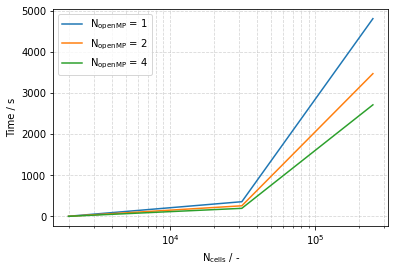

In [17]:
import pandas as pd
data_root = root + 'data/pool_fire/gc_3_1/rundir'
caselist = ['gc_1_1', 'gc_1_2', 'gc_1_3', 'gc_2_1', 'gc_2_2', 'gc_2_3', 'gc_3_1', 'gc_3_2', 'gc_3_3' ]
bm_dict = {}
for case in caselist:
    case_dict = {}
    data_root = root + f'data/pool_fire/{case}/rundir'
    sim = fdsreader.Simulation(data_root)
    case_dict['devc_temp'] = sim.devices[f'T_{1.0}'].data
    case_dict['sim_time'] = sim.devices['Time'].data
    case_dict['total_time'] = sim.cpu['Total T_USED (s)\n'][0]
    out_file = sim.out_file_path
    with open(out_file, 'r') as file:
        for line in file:
            if 'Total Number of Grid Cells' in line:
                case_dict['n_cells'] = int(line.split('Cells')[-1])
            if 'Number of OpenMP Threads:' in line:
                case_dict['n_open_mp'] = int(line.split('Number of OpenMP Threads:')[-1])
            if 'Number of MPI Processes:' in line:
                case_dict['n_mpi']= int(line.split('Number of MPI Processes:')[-1])
    
    bm_dict[case] = case_dict
bm_df = pd.DataFrame(bm_dict).T

for n_open_mp in [1,2,4]:
    df = bm_df[bm_df['n_open_mp']==n_open_mp]
    plt.plot(df['n_cells'], df['total_time'], label=f"$\sf N_{{openMP}}$ = {n_open_mp}")
plt.xscale('log')
# plt.yscale('log')
plt.xlabel("$\sf N_{{cells}}$ / -")
plt.ylabel("Time / s")
plt.grid(True, which="both", linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.savefig('figs/pool_fire_benchmarking.svg', bbox_inches='tight')

In [18]:
window = 10
for n_cells in [2000, 31250, 250000]:
    time = bm_df[bm_df['n_cells']==n_cells].iloc[0]['sim_time']
    temp = bm_df[bm_df['n_cells']==n_cells].iloc[0]['devc_temp']
    plt.plot(movingaverage(time, window), movingaverage(temp, window), label=f"$\sf N_{{cells}}$ = {n_cells}")
    plt.grid(True, which="both", linestyle='--', alpha=0.5)
    plt.legend(loc='lower right')
plt.xlabel("Time / s")
plt.ylabel("Temperature / $\sf ^\circ C$")
plt.savefig('figs/grid_convergence.svg', bbox_inches='tight')
plt.close()

:::{figure-md} fig-pool-fire-benchmarking

<img src="figs/pool_fire_benchmarking.svg" width="80%">

Total calculation time as a function of the total number of grid cells in the computational domain ( $\sf N_{cells}$ ) for different amount of openMP processes ($\sf N_{openMP}$). 
:::
 

:::{figure-md} fig-pool-fire-grid-convergence

<img src="figs/grid_convergence.svg" width="80%">

Checking grid convergence for device with quantity `TEMPERATURE` at XYZ (0, 0, 1). A grid size of 20 cm and above, which results in a total number of 31250 cells, does not show any significant change in temperature.
:::